### Graph transformation history

In [1]:
import nographs as nog
from graphviz import Digraph
import functools
import inspect

In [2]:
dict_1= {0:{1,2}, 1:{2,0}, 2:{0,1}, }
dict_2= {0:{1,}, 1:{2,3}, 2:{4,}, 3:{}, 4:{} }
#dict_2= {0:{1,}, 1:{}, 2:{4,}, 3:{}, 4:{} }

def forward(x, _):
    return dict_1[x]

In [3]:
def to_id(x):
    return f"{hash( x )}"
# https://www.graphviz.org/doc/info/attrs.html
node_style =dict( style='filled', shape='box', 
                                align='left',
                                fontsize='12',
                                ranksep='0.01',
                                height='0.02',width='0.04',)
gr_style = dict( linelength="16",rankdir='LR',size='16,8')#landscape="True",splines='curved' ,layout="neato"

def adapter_graphviz( wrapped ):
    dot = Digraph( node_attr = node_style, graph_attr = gr_style, )
    @functools.wraps( wrapped )
    def wrapper_bg( x, t ):
        node = dot.node( str(hash(x)), str(x) )
        for result in wrapped(x, t):
            dot.edge( str(hash( x )), str(hash( result )), )# label=f"{str(x)}-{str(result)}",
            yield result
    wrapper_bg.dot = dot
    return wrapper_bg
    

In [4]:
class EdgeSplitter:
    def __init__(self, wrapped):
        self.in_history = True
        functools.update_wrapper(self, wrapped )
        self.newbies = set()
    def __call__(self, x, t):

        if x in self.newbies:
            yield x[1]
        else:
            for result in self.__wrapped__(x, t):
                # creating new vertex at the middle of edge, new id is tuple of edge's ends
                self.newbies.add((x, result))
                yield (x, result)



In [5]:
import ast
class NameMod:
    def __init__(self, wrapped):
        self.in_history = False
        functools.update_wrapper(self, wrapped )
    def __call__(self, x, t):
        #print(x, ast.literal_eval(x),type(ast.literal_eval(x)) )
        for result in self.__wrapped__( ast.literal_eval(x[1:-1]), t):
            #print("---",result,type(result) )
            yield f"-{result}-"

In [6]:
@adapter_graphviz
@NameMod
@EdgeSplitter
def stringy(x, _):
    #print("===",x,type(x) )
    return dict_1[x]
    
trav_forward = nog.TraversalBreadthFirst( stringy )
trav_forward.start_from( "-0-", build_paths=True )
str( list(trav_forward) )
0

0

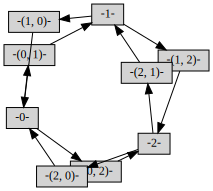

In [7]:
#print(double_splitted.dot.source)
stringy.dot.graph_attr['layout']='neato'
stringy.dot

In [8]:
def wrg( f, _ ):
    print(f, hasattr(f,"in_history"))
    if hasattr( f, "__wrapped__" ):
        return (f.__wrapped__,)
    return ()

trav_forward = nog.TraversalBreadthFirst( wrg )
trav_forward.start_from( stringy, build_paths=True )
str( list(trav_forward) )

<function stringy at 0x0000019935B67F60> True
<__main__.NameMod object at 0x00000199350DB250> True
<__main__.EdgeSplitter object at 0x0000019935B82D10> True
<function stringy at 0x0000019935B67EC0> False


'[<__main__.NameMod object at 0x00000199350DB250>, <__main__.EdgeSplitter object at 0x0000019935B82D10>, <function stringy at 0x0000019935B67EC0>]'

In [9]:
x='1'
print(x, ast.literal_eval(x),type(ast.literal_eval(x)) )

1 1 <class 'int'>


In [10]:
class GraphMorph:
    def __init__(self, wrapped):
        functools.update_wrapper(self, wrapped )
    def __call__(self, x, t):
        yield from self.__wrapped__( x, t )

class GraphMorphDecorateNodes(GraphMorph):
    def __init__(self,*argc,**argv):
        super().__init__(*argc,**argv)
    @staticmethod
    def dress( x,):
        return x
    @staticmethod
    def undress( x,):
        return x
    def __call__(self, x, t):
        yield from map( self.dress, self.__wrapped__( self.undress(x), t ) )

class DecoName(GraphMorphDecorateNodes):
    def __init__(self,*argc,**argv):
        super().__init__(*argc,**argv)
    @staticmethod
    def dress( x,):
        return f"-{x}-"
    @staticmethod
    def undress( x,):
        return ast.literal_eval(x[1:-1])

In [11]:
class FreeForget(GraphMorph):  # All possible paths
    def __init__(self,*argc,**argv):        super().__init__(*argc,**argv)
        
    def __call__(self, x, t):
        yield x # identity morphism
        for ch1 in self.__wrapped__( x, t ):
            yield from self.__call__(ch1, t) # recursion

In [12]:
class Labeler(GraphMorph):  # All possible paths
    def node_label( x ):
        return str(x)
    def node_id( x ):
        return str(hash(x))
    def __init__(self,*argc,**argv):
        super().__init__(*argc,**argv)

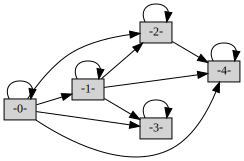

In [13]:
def new_cat():
    @adapter_graphviz
    @DecoName
    @FreeForget
    def cat(x, _):
        return dict_2[x]
    return cat
    
cat_1 = new_cat()
trav_forward = nog.TraversalBreadthFirst( cat_1 )
trav_forward.start_from( '-0-', )
str( list(trav_forward) )
cat_1.dot

In [14]:
print(stringy.dot.source)

digraph {
	graph [layout=neato linelength=16 rankdir=LR size="16,8"]
	node [align=left fontsize=12 height=0.02 ranksep=0.01 shape=box style=filled width=0.04]
	5078673343425508980 [label="-0-"]
	5078673343425508980 -> -5201040291766649065
	5078673343425508980 -> 9187885044487279653
	-5201040291766649065 [label="-(0, 1)-"]
	-5201040291766649065 -> -370674786830551176
	9187885044487279653 [label="-(0, 2)-"]
	9187885044487279653 -> -1903426511067498440
	-370674786830551176 [label="-1-"]
	-370674786830551176 -> -5915930550137853257
	-370674786830551176 -> 4708980989421163437
	-1903426511067498440 [label="-2-"]
	-1903426511067498440 -> 878133081457753004
	-1903426511067498440 -> 66262408773365745
	-5915930550137853257 [label="-(1, 0)-"]
	-5915930550137853257 -> 5078673343425508980
	4708980989421163437 [label="-(1, 2)-"]
	4708980989421163437 -> -1903426511067498440
	878133081457753004 [label="-(2, 0)-"]
	878133081457753004 -> 5078673343425508980
	66262408773365745 [label="-(2, 1)-"]
	6626240

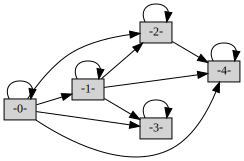

In [15]:
#cat.dot = Digraph( node_attr = node_style, graph_attr = gr_style, )
cat_2 = new_cat()
trav_forward = nog.TraversalBreadthFirst( cat_2 )
trav_forward.start_from( '-0-', )
str( list(trav_forward) )
cat_2.dot

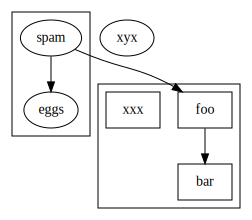

In [16]:
import graphviz  
q = graphviz.Digraph(name='master')

p = graphviz.Digraph(name='cluster_1')
p.edge('spam', 'eggs')

c = graphviz.Digraph(name='cluster_0', node_attr={'shape': 'box'})
c.edge('foo', 'bar')
c.node('xxx')

p.edge('spam', 'foo')
q.subgraph(c)
q.subgraph(p)
q.node('xyx')
q

In [17]:
class IDFunctor(GraphMorphDecorateNodes):
    def __init__(self,*argc,**argv):
        super().__init__(*argc,**argv)
    @staticmethod
    def dress( x,):
        return f"-{x}-"
    @staticmethod
    def undress( x,):
        return ast.literal_eval(x[1:-1])
    def __call__(self, x, t):
        if type(x) is int:
            yield from                  self.__wrapped__(              x,  t )
            yield self.dress(x)
        else:
            yield from map( self.dress, self.__wrapped__( self.undress(x), t ) )
            #yield from                  self.__wrapped__( self.undress(x), t )

In [18]:
class graphviz_bipart( GraphMorph ):
    def __init__(self, wrapped ):
        super().__init__( wrapped )
        self.dot = {}
        self.dot[False] = Digraph( name="cluster_0" )
        self.dot[True]  = Digraph( name="cluster_1",node_attr={'shape': 'box'} )
    def predicate(self,x):
        return type(x) is int
    def __call__(self, x, t):
        node = self.dot[self.predicate(x)].node( to_id(x), str(x) )
        for result in self.__wrapped__(x, t):
            colour = 'black' if self.predicate(x) == self.predicate(result) else 'red'
            # label=f"{str(x)}-{str(result)}",
            self.dot[self.predicate(x)].edge( to_id(x), to_id(result), color=colour)
            yield result
    def get_dot(self):
        both = graphviz.Digraph( name='master')
        both.subgraph(self.dot[False])
        both.subgraph(self.dot[True])
        return both       

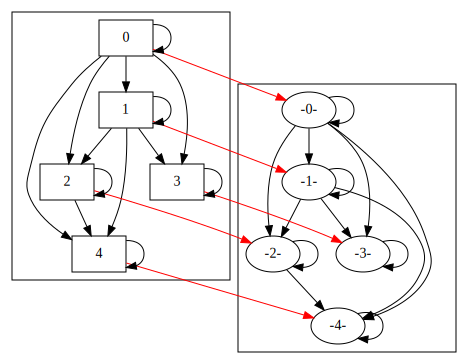

In [19]:
def cat_dog():
    @graphviz_bipart
    @IDFunctor
    @FreeForget
    def cat(x, _):
        return dict_2[x]
    return cat

cat_3 = cat_dog()
trav_forward = nog.TraversalBreadthFirst( cat_3 )
trav_forward.start_from( 0, )
str( list(trav_forward) )
the_dot = cat_3.get_dot()
the_dot

In [20]:
print(the_dot.source)

digraph master {
	subgraph cluster_0 {
		5078673343425508980 [label="-0-"]
		5078673343425508980 -> 5078673343425508980 [color=black]
		5078673343425508980 -> -370674786830551176 [color=black]
		5078673343425508980 -> -1903426511067498440 [color=black]
		5078673343425508980 -> 3928109031730361181 [color=black]
		5078673343425508980 -> -4218034394202075313 [color=black]
		-370674786830551176 [label="-1-"]
		-370674786830551176 -> -370674786830551176 [color=black]
		-370674786830551176 -> -1903426511067498440 [color=black]
		-370674786830551176 -> 3928109031730361181 [color=black]
		-370674786830551176 -> -4218034394202075313 [color=black]
		-1903426511067498440 [label="-2-"]
		-1903426511067498440 -> -1903426511067498440 [color=black]
		-1903426511067498440 -> 3928109031730361181 [color=black]
		3928109031730361181 [label="-4-"]
		3928109031730361181 -> 3928109031730361181 [color=black]
		-4218034394202075313 [label="-3-"]
		-4218034394202075313 -> -4218034394202075313 [color=black]
	}


In [21]:
print(q.source)

digraph master {
	subgraph cluster_0 {
		node [shape=box]
		foo -> bar
		xxx
	}
	subgraph cluster_1 {
		spam -> eggs
		spam -> foo
	}
	xyx
}



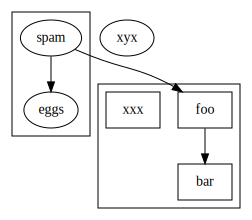

In [22]:
s = q.source
g = Digraph()

source_lines = str(s).splitlines()
# Remove 'digraph tree {'
source_lines.pop(0)
# Remove the closing brackets '}'
source_lines.pop(-1)
# Append the nodes to body
g.body += source_lines
g